# Project 4 - Advanced Lane Detection

The goal of this project is to define a software pipeline that identifies the lane boundaries in a video from a front-facing camera on a car. The front facing camera is calibrated using 20 chessboard images and the pipeline is tested on a number of still road images. The pipeline is then implmented on a video file and detects the lane lines, calculates the road curvature, and calculates the distance from lane center of the camera.

This jupyter notebook provides a read through of each section of the pipeline and provides examples of the inputs and outputs of those sections. The writeup is sectioned as follows:

0. Preliminaries
1. Camera Calibration
2. Image Processing Pipeline
3. Video Processing Pipeline
4. Video Output
5. Discussion

For additional information, see the project README located here: https://github.com/mblomquist/Udacity-SDCND-Advanced_Lane_Detection-P4

## 1. Preliminaries

Load libraries to be used.

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

## 2. Camera Calibration

### 2.1 Compute Camera Matrix

#### 2.1.1 Load Calibration Images and Determine Chessboard Corners

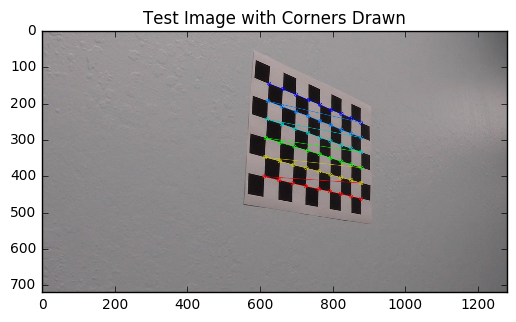

In [3]:
# Read in calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Create empy arrays for object points and images points
objpoints = []
imgpoints = []

# Define Number of Corners
nx = 9
ny = 6

# Define Object Points
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Fill Object and Image Arrays
for cal_name in images:
    img = cv2.imread(cal_name)
        
    ret, corners = cv2.findChessboardCorners(img, (nx, ny), None)
    
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        
        plt.imshow(img)
        plt.title('Test Image with Corners Drawn')
        

#### 2.1.2 Calculate Camera Matrix, Un-distort calibration image, and Show Input/Ouput Images

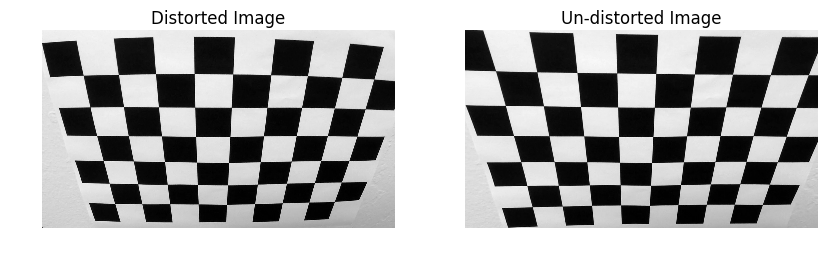

In [4]:
# Load Test Image
test_img = cv2.imread(images[11],0)

# Caluclate Distortion Matrix
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, test_img.shape[::-1],None,None)

c_mtx = mtx
d_mtx = dist

global c_mtx
global d_mtx

dst = cv2.undistort(test_img, mtx, dist, None, mtx)

# Display both distorted and undistorted images
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Distorted Image')
plt.imshow(test_img, cmap='gray')


plt.subplot(1, 2, 2)
plt.imshow(dst, cmap='gray')
plt.axis('off')
plt.title('Un-distorted Image')

## 3. Image Processing Pipeline

### 3.1 Distortion Correction

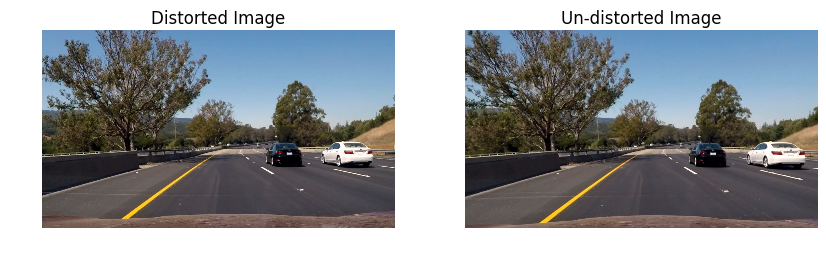

In [5]:
# Load Test Images
test_images = glob.glob('./test_images/*.jpg')

# Correct Distortion for a Test Image
img_test = cv2.imread(test_images[7],1)
dst = cv2.undistort(img_test, mtx, dist, None, mtx)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Distorted Image')
plt.imshow(cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Un-distorted Image')

### 3.2 Color Thresholding

#### 3.2.1 Create HSV Binary

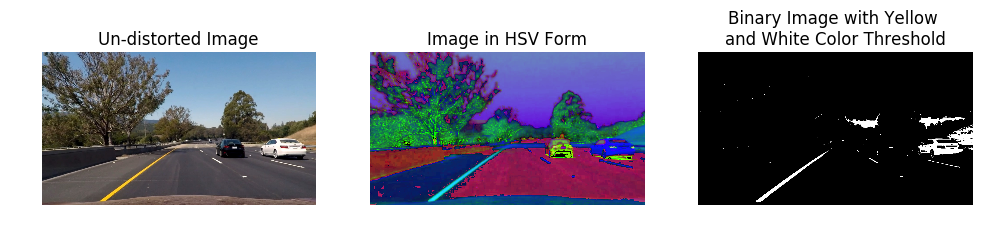

In [8]:
# Convert Image to HSV Color Space
img = cv2.cvtColor(dst, cv2.COLOR_BGR2HSV)

''' Note: This idea came from Mehdi Sqalli here:
      https://medium.com/@MSqalli/advanced-lane-detection-6a769de0d581#.ta6un32x9 '''

# Define Thresholding Max and Min Conditions (Yellow)
yellow_min = np.array([15,100,120], np.uint8)
yellow_max = np.array([80,255,255], np.uint8)

# Define Thresholding Max and Min Conditions (White)
white_min = np.array([0,0,200], np.uint8)
white_max = np.array([255,30,255], np.uint8)

# Create Masks for Yellow and White Lines
yellow_mask = cv2.inRange(img, yellow_min, yellow_max)
white_mask = cv2.inRange(img, white_min, white_max)

# Create Binary Output
hsv_binary = np.zeros_like(img[:,:,0])
hsv_binary[((yellow_mask != 0) | (white_mask != 0))] = 1

plt.figure(figsize=(12,4))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.title('Un-distorted Image')
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))

plt.subplot(1, 3, 2)
plt.imshow(img)
plt.axis('off')
plt.title('Image in HSV Form')

plt.subplot(1, 3, 3)
plt.imshow(hsv_binary, cmap="gray")
plt.axis('off')
plt.title('Binary Image with Yellow \nand White Color Threshold')

#### 3.2.2 Create HLS Binary

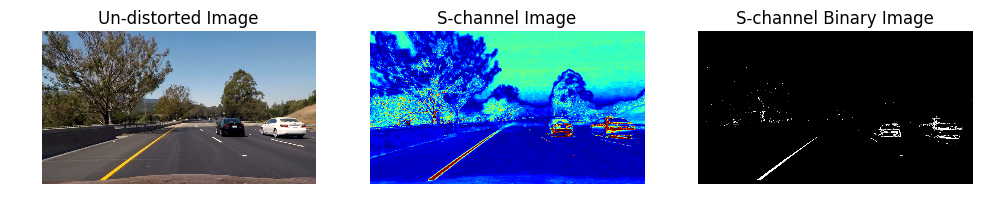

In [11]:
# Convert Image to Lab Color Space
img = cv2.cvtColor(dst, cv2.COLOR_BGR2HLS)

# Define Thresholding Max and Min Conditions (White)
thresh_min = 240
thresh_max = 255

# Strip b-channel values
img = img[:,:,2]

# Create Binary Output
hls_binary = np.zeros_like(img)
hls_binary[(img > thresh_min) & (img <= thresh_max)] = 1

plt.figure(figsize=(12,4))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.title('Un-distorted Image')
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))

plt.subplot(1, 3, 2)
plt.imshow(img)
plt.axis('off')
plt.title('S-channel Image')

plt.subplot(1, 3, 3)
plt.imshow(hls_binary, cmap="gray")
plt.axis('off')
plt.title('S-channel Binary Image')

#### 3.2.3 Creating a HLS Gradient Binary

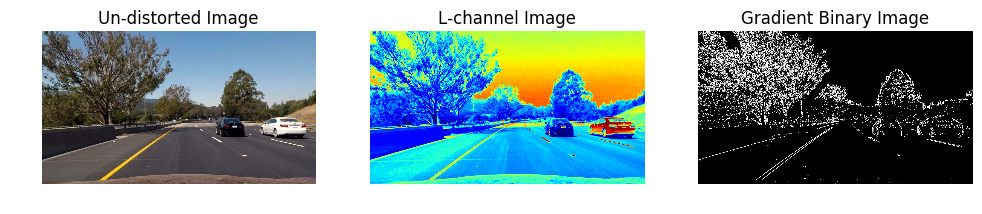

In [12]:
# Convert Image to Gray-Scale
img = cv2.cvtColor(dst, cv2.COLOR_BGR2HLS)

img = img[:,:,1]

# Use Sobel Function to Take the X-Direction Gradient
sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0,ksize=-1)
sobelx = np.absolute(sobelx)

sobel = (255*sobelx/np.max(sobelx))

# Threshold the Gradient
thresh_min = 20
thresh_max = 100

gradient_binary = np.zeros_like(sobel)
gradient_binary[(sobel >= thresh_min) & (sobel <= thresh_max)] = 1

plt.figure(figsize=(12,4))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.title('Un-distorted Image')
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))

plt.subplot(1, 3, 2)
plt.imshow(img)
plt.axis('off')
plt.title('L-channel Image')

plt.subplot(1, 3, 3)
plt.imshow(gradient_binary, cmap='gray')
plt.axis('off')
plt.title('Gradient Binary Image')

#### 3.2.4 Combined Thresholds

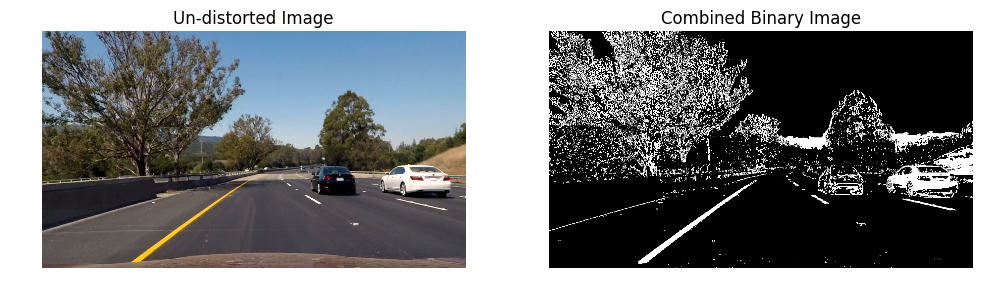

In [17]:
# Combine Binaries
combined_binary = np.zeros_like(dst[:,:,0])
combined_binary[( (gradient_binary == 1) | (hsv_binary == 1) | (hls_binary == 1) )] = 1

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Un-distorted Image')
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.imshow(combined_binary, cmap="gray")
plt.axis('off')
plt.title('Combined Binary Image')

### 3.2 Test On Hard Images

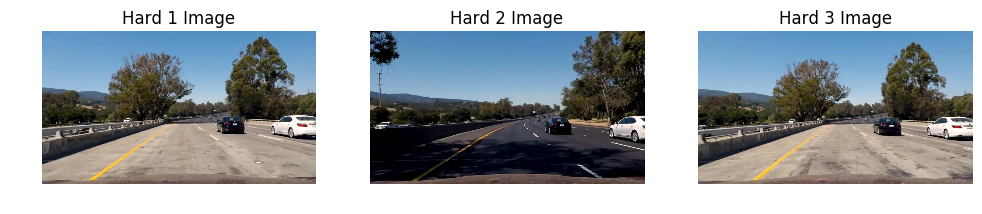

In [18]:
# Correct Distortion for a Test Image
img_hard1 = cv2.imread('hard_images/h_test1.jpg',1)
img_hard2 = cv2.imread('hard_images/h_test2.jpg',1)
img_hard3 = cv2.imread('hard_images/h_test3.jpg',1)

hard1 = cv2.undistort(img_hard1, mtx, dist, None, mtx)
hard2 = cv2.undistort(img_hard2, mtx, dist, None, mtx)
hard3 = cv2.undistort(img_hard3, mtx, dist, None, mtx)

plt.figure(figsize=(12,4))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.title('Hard 1 Image')
plt.imshow(cv2.cvtColor(hard1, cv2.COLOR_BGR2RGB))


plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(hard2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Hard 2 Image')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(hard3, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Hard 3 Image')

#### 3.3.1 Define Functions for Quick Implementation

In [19]:
def combine_thresh(img):
    
    # Define Thresholding Max and Min Condition
    gradient_binary = gradient_thresh(img)
    hsv_binary = hsv_thresh(img)
    hls_binary = hls_thresh(img)

    combined_binary = np.zeros_like(img[:,:,0])
    combined_binary[( (gradient_binary == 1) | (hsv_binary == 1) | (hls_binary == 1) )] = 1
    return combined_binary

def gradient_thresh(img):

    # Convert Image to Gray-Scale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    
    img = img[:,:,1]
    
    # Use Sobel Function to Take the X-Direction Gradient
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0,ksize=-1)
    sobelx = np.absolute(sobelx)

    sobel = (255*sobelx/np.max(sobelx))

    # Threshold the Gradient
    thresh_min = 20
    thresh_max = 100

    gradient_binary = np.zeros_like(sobel)
    gradient_binary[(sobel >= thresh_min) & (sobel <= thresh_max)] = 1

    return gradient_binary

def hls_thresh(img):

    # Convert Image to Lab Color Space
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

    # Define Thresholding Max and Min Conditions (White)
    thresh_min = 240
    thresh_max = 255

    # Strip b-channel values
    img = img[:,:,2]

    # Create Binary Output
    hls_binary = np.zeros_like(img)
    hls_binary[(img > thresh_min) & (img <= thresh_max)] = 1

    return hls_binary

def hsv_thresh(img):

    # Convert Image to HSV Color Space
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    ''' Note: This idea came from Mehdi Sqalli here:
          https://medium.com/@MSqalli/advanced-lane-detection-6a769de0d581#.ta6un32x9 '''

    # Define Thresholding Max and Min Conditions (Yellow)
    yellow_min = np.array([15,100,120], np.uint8)
    yellow_max = np.array([80,255,255], np.uint8)

    # Define Thresholding Max and Min Conditions (White)
    white_min = np.array([0,0,200], np.uint8)
    white_max = np.array([255,30,255], np.uint8)

    # Create Masks for Yellow and White Lines
    yellow_mask = cv2.inRange(img, yellow_min, yellow_max)
    white_mask = cv2.inRange(img, white_min, white_max)

    # Create Binary Output
    hsv_binary = np.zeros_like(img[:,:,0])
    hsv_binary[((yellow_mask != 0) | (white_mask != 0))] = 1

    return hsv_binary

#### 3.3.2 Test Images

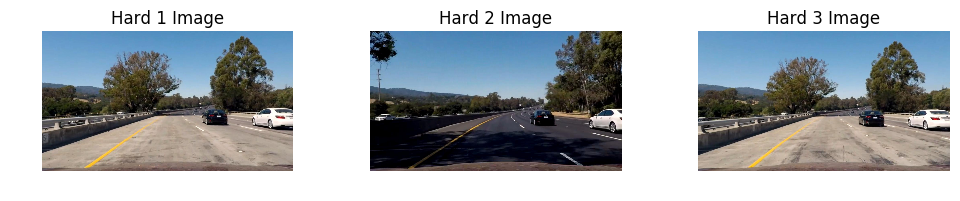

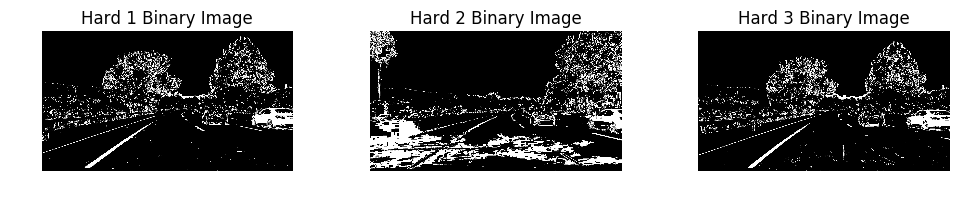

In [21]:
cb_hard1 = combine_thresh(hard1)
cb_hard2 = combine_thresh(hard2)
cb_hard3 = combine_thresh(hard3)

plt.figure(figsize=(12,4))
plt.subplot(2, 3, 1)
plt.axis('off')
plt.title('Hard 1 Image')
plt.imshow(cv2.cvtColor(hard1, cv2.COLOR_BGR2RGB))

plt.subplot(2, 3, 2)
plt.imshow(cv2.cvtColor(hard2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Hard 2 Image')

plt.subplot(2, 3, 3)
plt.imshow(cv2.cvtColor(hard3, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Hard 3 Image')

plt.figure(figsize=(12,4))
plt.subplot(2, 3, 4)
plt.axis('off')
plt.title('Hard 1 Binary Image')
plt.imshow(cb_hard1, cmap="gray")

plt.subplot(2, 3, 5)
plt.imshow(cb_hard2, cmap="gray")
plt.axis('off')
plt.title('Hard 2 Binary Image')

plt.subplot(2, 3, 6)
plt.imshow(cb_hard3, cmap="gray")
plt.axis('off')
plt.title('Hard 3 Binary Image')

### 3.4 Perspective Transformation

#### 3.4.1 Perform Perspective Transform and show Bird's Eye Images

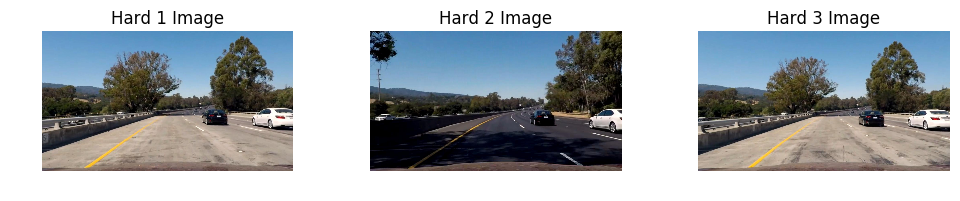

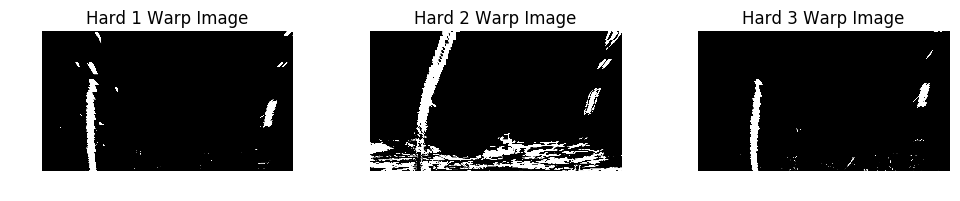

In [22]:
# Define a Perspective Transform Function
def warp(img):
    
    img_size = (img.shape[1], img.shape[0])
    
    # Coordinates from: https://medium.com/@MSqalli/advanced-lane-detection-6a769de0d581#.gjju6sgwt
    new_mtx = np.float32([[260, 0],
                          [1040, 0],
                          [1040, 720], 
                          [260, 720]])

    src_mtx = np.float32([[580,460],
                          [700,460],
                          [1040,680], 
                          [260,680]])

    M = cv2.getPerspectiveTransform(src_mtx, new_mtx)
    Minv = cv2.getPerspectiveTransform(new_mtx, src_mtx)
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, Minv

warp1, Minv = warp(cb_hard1)
warp2, Minv = warp(cb_hard2)
warp3, Minv = warp(cb_hard3)

plt.figure(figsize=(12,4))
plt.subplot(2, 3, 1)
plt.axis('off')
plt.title('Hard 1 Image')
plt.imshow(cv2.cvtColor(hard1, cv2.COLOR_BGR2RGB))

plt.subplot(2, 3, 2)
plt.imshow(cv2.cvtColor(hard2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Hard 2 Image')

plt.subplot(2, 3, 3)
plt.imshow(cv2.cvtColor(hard3, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Hard 3 Image')

plt.figure(figsize=(12,4))
plt.subplot(2, 3, 4)
plt.axis('off')
plt.title('Hard 1 Warp Image')
plt.imshow(warp1, cmap="gray")

plt.subplot(2, 3, 5)
plt.imshow(warp2, cmap="gray")
plt.axis('off')
plt.title('Hard 2 Warp Image')

plt.subplot(2, 3, 6)
plt.imshow(warp3, cmap="gray")
plt.axis('off')
plt.title('Hard 3 Warp Image')

### 3.5 Find Lane Lines

#### 3.5.1 Determine Lane Location with a Histogram

C:\Users\Matt\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app
C:\Users\Matt\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
C:\Users\Matt\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


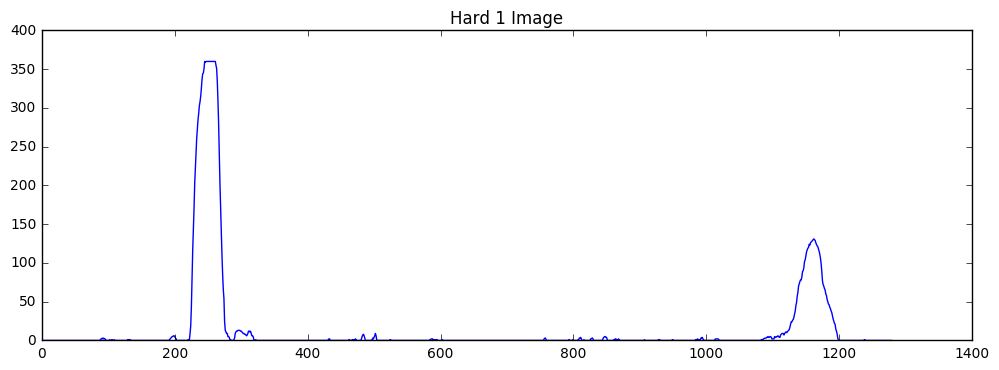

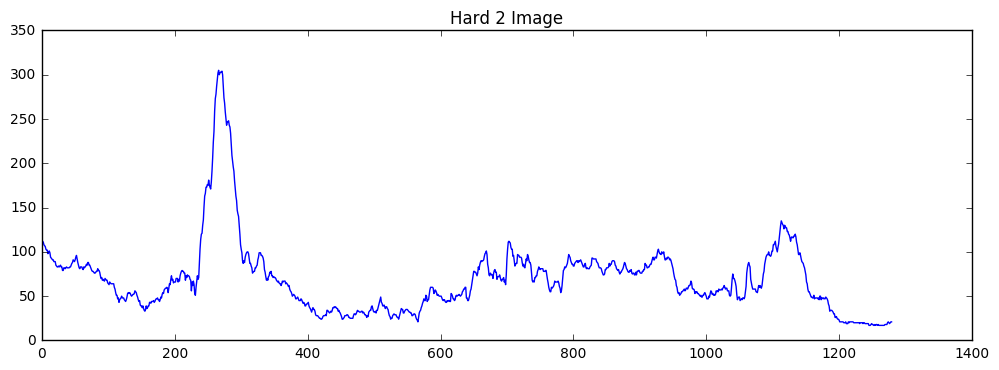

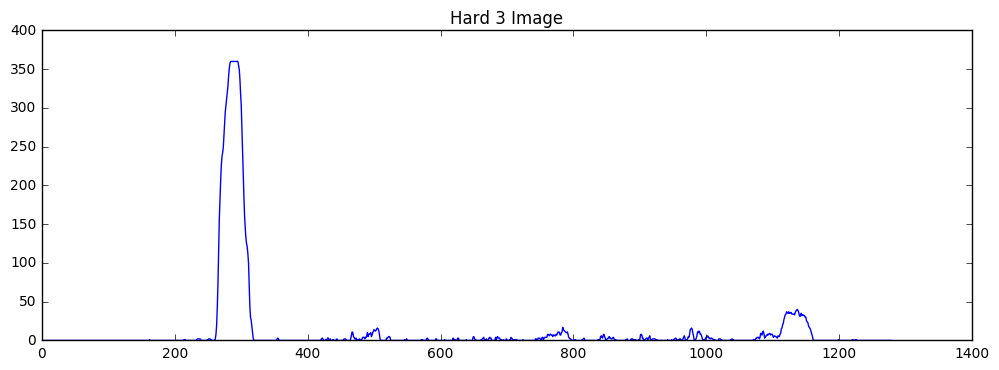

In [25]:
# Create a Histogram of the Non-Zero Values of the Warped Binary
histogram1 = np.sum(warp1[warp1.shape[0]/2:,:], axis=0)
histogram2 = np.sum(warp2[warp2.shape[0]/2:,:], axis=0)
histogram3 = np.sum(warp3[warp3.shape[0]/2:,:], axis=0)

plt.figure(figsize=(12,4))
plt.title('Hard 1 Image')
plt.plot(histogram1)

plt.figure(figsize=(12,4))
plt.title('Hard 2 Image')
plt.plot(histogram2)

plt.figure(figsize=(12,4))
plt.title('Hard 3 Image')
plt.plot(histogram3)

#### 3.5.2 Determine Lane Lines Via Polyfit and Sliding Window Search

C:\Users\Matt\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
C:\Users\Matt\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


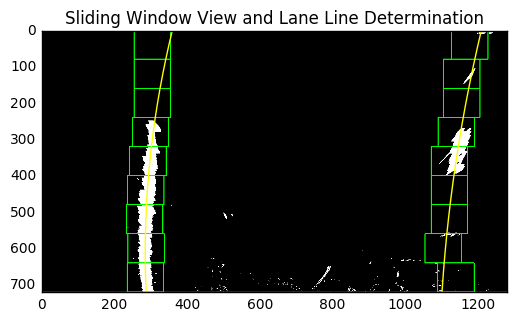

In [29]:
def find_lanes(img_warped):
    
    histogram = np.sum(img_warped[img_warped.shape[0]/2:,:], axis=0)

    # Take a histogram of the bottom half of the image
    histogram = np.sum(img_warped[img_warped.shape[0]/2:,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img_warped, img_warped, img_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(img_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img_warped.shape[0] - (window+1)*window_height
        win_y_high = img_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, img_warped.shape[0]-1, img_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return ploty, left_fitx, right_fitx, left_fit, right_fit, out_img


ploty, left_fitx, right_fitx, left_fit, right_fit, out_img = find_lanes(warp3)

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.title('Sliding Window View and Lane Line Determination')

#### 3.5.3 Create Quick Lane Line Search (Used for Video Processing)

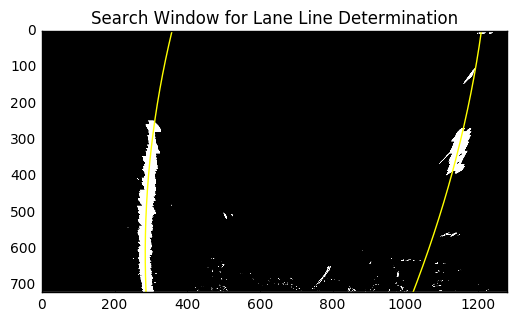

In [39]:
def update_lanes(img_warped, left_fit, right_fit):
    
    # It's now much easier to find line pixels!
    nonzero = img_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    margin = 100
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_warped.shape[0]-1, img_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return ploty, left_fitx, right_fitx, left_fit, right_fit

ploty, left_fitx, right_fitx, left_fit, right_fit = update_lanes(warp3, left_fit, right_fit)

plt.imshow(warp3, cmap="gray")
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.title('Search Window for Lane Line Determination')

### 3.6 Calculate Curvature and Center Distance

#### 3.6.1 Calculate Lane Curvature

In [50]:
def calc_curve(ploty, left_fitx, right_fitx):

    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad

left_curverad, right_curverad = calc_curve(ploty, left_fitx, right_fitx)

# Now our radius of curvature is in meters
print('Left Curvature: ', left_curverad, 'm')
print('Right Curvature: ',  right_curverad, 'm')
print('Averaged Curvature: ',  (left_curverad + right_curverad)/2.0, 'm')

Left Curvature:  836.593674361 m
Right Curvature:  972.153578431 m
Averaged Curvature:  904.373626396 m


#### 3.6.2 Calculate Center Distance

In [51]:
# Calculate Center Distance
calculated_center = (left_fitx[719] + right_fitx[719]) / 2.0
lane_center = (calculated_center - 1280 / 2.0) * xm_per_pix
        
print('Lane Center: ', lane_center, 'm')

Lane Center:  0.0747889889227 m


### 3.7 Prepare Output Image

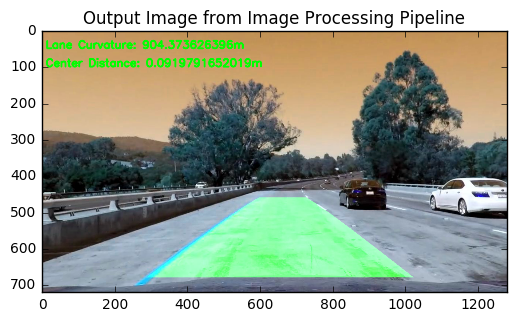

In [55]:
def create_output(img, ploty, left_fitx, right_fitx, left_curverad, right_curverad, Minv):
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    color_warp = cv2.fillPoly(warp_zero, pts.astype(int), (0,255,0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (dst.shape[1], dst.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, .7, 0)
    
    # Calculate Center Distance
    calculated_center = (left_fitx[700] + right_fitx[700]) / 2.0
    lane_center = (calculated_center - 1280 / 2.0) * 3.7/700

    # Add text to image
    top_text = 'Lane Curvature: ' + str((left_curverad+right_curverad)/2.0) + 'm'
    bot_text = 'Center Distance: ' + str(lane_center) + 'm'

    result - cv2.putText(result, top_text, (10,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 3,cv2.LINE_AA)
    result - cv2.putText(result, bot_text, (10,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 3,cv2.LINE_AA)
    
    return result

result = create_output(hard3, ploty, left_fitx, right_fitx, left_curverad, right_curverad, Minv)

plt.imshow(result)
plt.title('Output Image from Image Processing Pipeline')

### 3.8 Image Pipeline

#### 3.8.1 Define the Image Processing Pipeline

In [56]:
# Create Pipeline Function
def process_image(img):
    
    # Distortion Correction
    img = cv2.undistort(img, c_mtx, d_mtx, None, c_mtx)
    
    img_binary = combine_thresh(img)
    
    img_warped, Minv = warp(img_binary)
        
    ploty, left_fitx, right_fitx, left_fit, right_fit, img_out = find_lanes(img_warped)
    
    left_curverad, right_curverad = calc_curve(ploty, left_fitx, right_fitx)
    
    img_out = create_output(img, ploty, left_fitx, right_fitx, left_curverad, right_curverad, Minv)
    
    return img_out

### 3.9 Image Processing Test

C:\Users\Matt\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
C:\Users\Matt\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


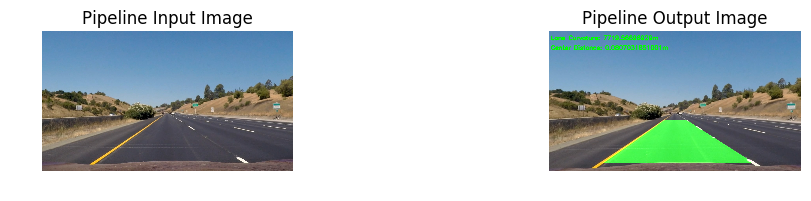

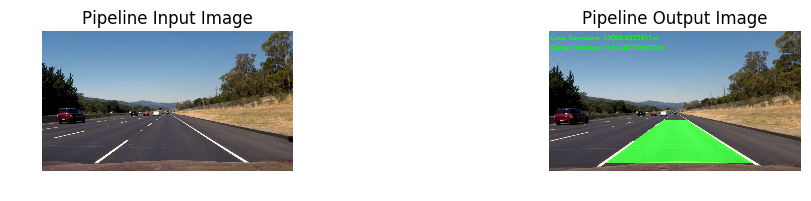

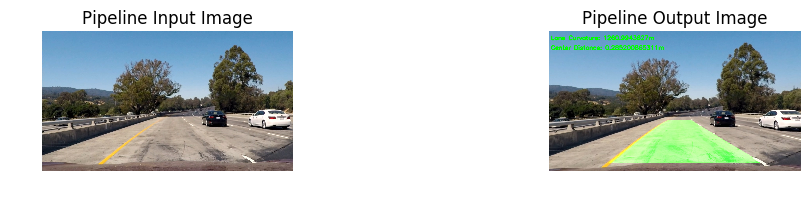

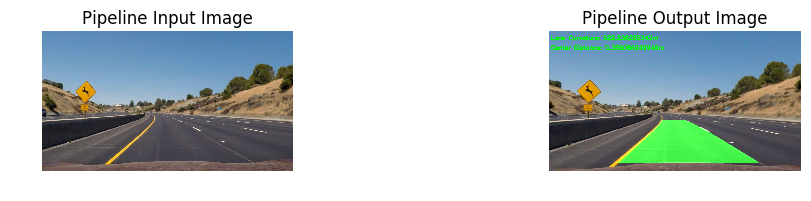

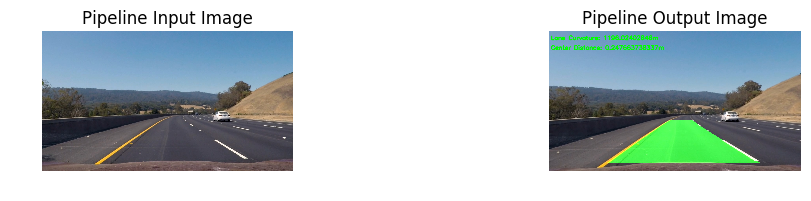

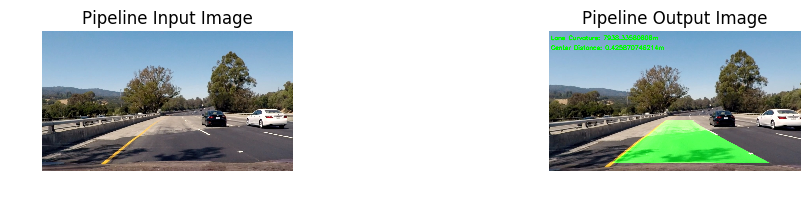

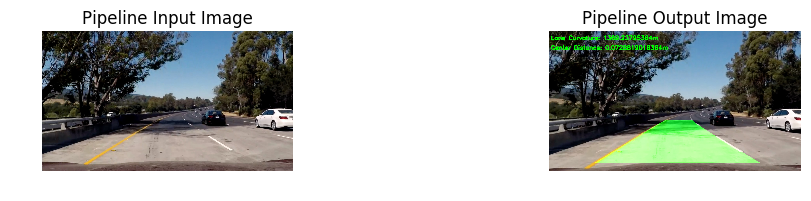

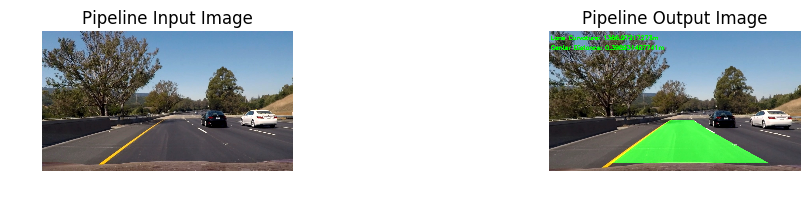

In [57]:
# Run Image Processing Pipeline on Each Test Image
for i in range(len(test_images)):
    img_test = cv2.imread(test_images[i],1)
    img_out = process_image(img_test)
    
    # Show Images
    plt.figure(figsize=(12,4))
    plt.subplot(2, 2, 1)
    plt.axis('off')
    plt.title('Pipeline Input Image')
    plt.imshow(cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB))

    plt.subplot(2, 2, 2)
    plt.imshow(cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Pipeline Output Image')

## 4. Video Processing Pipeline

### 4.1 Define Line Class to Create Running Data

In [60]:
# Create Line Class
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        
        #average x values of the fitted line over the last n iterations
        self.avgx_left = None   
        self.avgx_right = None 
        
        # Last Fitted Lines
        self.fit_left = None
        self.fit_right = None
        
        # Last Fitted Lines
        self.fitx_left = None
        self.fitx_right = None
        
        # Intercepts
        self.int_left = None
        self.int_right = None
        
        # Iteration for Weights
        self.lane_itr = 0
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
        #x values for detected line pixels
        self.allx = None  
        
        #y values for detected line pixels
        self.ally = None

### 4.2 Define Video Processing Pipeline

In [61]:
# Create Pipeline Function
def process_video(img):
    
    # Distortion Correction
    img = cv2.undistort(img, c_mtx, d_mtx, None, c_mtx)
    
    img_binary = combine_thresh(img)
    
    img_warped, Minv = warp(img_binary)
        
    if line.detected == False:
        ploty, left_fitx, right_fitx, left_fit, right_fit, out_img = find_lanes(img_warped)
        
        line.fit_left = left_fit
        line.fit_right = right_fit
        
        line.fitx_left = left_fitx
        line.fitx_right = right_fitx
        
        line.detected = True
        
    else:
        ploty, left_fitx, right_fitx, left_fit, right_fit = update_lanes(img_warped, line.fit_left, line.fit_right)
        
        if abs(left_fit[0]) > 5*abs(line.fit_left[0]):
            
            weights_left1 = np.zeros_like(line.fitx_left)+1.5
            weights_left2 = np.zeros_like(left_fitx)+.5
            
            weights_right1 = np.zeros_like(line.fitx_right)+1.5
            weights_right2 = np.zeros_like(right_fitx)+.5
            
            left_fitx = np.hstack((line.fitx_left,left_fitx))
            weights_left = np.hstack((weights_left1,weights_left2))
            
            right_fitx = np.hstack((line.fitx_right,right_fitx))
            weights_right = np.hstack((weights_right1,weights_right2))
            
            ploty = np.hstack((ploty,ploty))
            
            left_fit = np.polyfit(ploty,left_fitx,2,w=weights_left)
            right_fit = np.polyfit(ploty,right_fitx,2,w=weights_right)
            
            line.fit_left = (left_fit + 24*line.fit_left)/25
            line.fit_right = (right_fit + 24*line.fit_right)/25
            
            left_fitx = left_fit[0]*(ploty**2) + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*(ploty**2) + right_fit[1]*ploty + right_fit[2]
            
        else:
            
            line.fit_left = (left_fit + 24*line.fit_left)/25
            line.fit_right = (right_fit + 24*line.fit_right)/25
            
            line.fitx_left = left_fitx
            line.fitx_right = right_fitx
            
    left_curverad, right_curverad = calc_curve(ploty, left_fitx, right_fitx)
    
    img_out = create_output(img, ploty, left_fitx, right_fitx, left_curverad, right_curverad, Minv)
    
    return img_out

### 4.3 Load Imports for Using Videos

In [62]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### 4.4 Video Processing Test (Project Video)

In [63]:
line = Line()

project_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_video) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:29<00:00,  8.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 2min 30s


#### 4.4.1 Show Output Video

In [64]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

### 4.5 Video Processing Test (Challenge Video)

In [66]:
line = Line()

challenge_output = 'challenge_video_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
challenge_clip = clip1.fl_image(process_video) #NOTE: this function expects color images!!
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [00:54<00:00,  8.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

Wall time: 55.3 s


#### 4.5.1 Show Output

In [67]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

### 4.6 Video Processing Test (Hard Challenge Video)

In [68]:
hchallenge_output = 'hard_challenge_video_output.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
hchallenge_clip = clip1.fl_image(process_video) #NOTE: this function expects color images!!
%time hchallenge_clip.write_videofile(hchallenge_output, audio=False)

[MoviePy] >>>> Building video hard_challenge_video_output.mp4
[MoviePy] Writing video hard_challenge_video_output.mp4


 93%|████████████████████████████████████████████████████████████████████████▊     | 1121/1200 [02:35<00:09,  8.06it/s]

TypeError: expected non-empty vector for x

#### 4.6.1 Show Output

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(hchallenge_output))